# Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud

Read in training data 

In [2]:
X_train = pd.read_table('../training_text.txt', sep = '\|\|', engine = 'python')
X_train.columns = ['text']
y_train = pd.read_table('../training_variants.txt', sep = ',', index_col = 0)

Tokenize and filter stop words

In [3]:
count_vect = CountVectorizer(stop_words = 'english')
X_train_counts = count_vect.fit_transform(X_train['text'])

Build a word index dictionary for later use

In [4]:
word_to_index = {word:i for i, word in enumerate(count_vect.get_feature_names())}
index_to_word = {i:word for i, word in enumerate(count_vect.get_feature_names())}
index_to_word[word_to_index['cell']]

'cell'

# LDA Classifier
mutation classes: <br>
1 - Likely Loss-of-function <br>
2 - Likely Gain-of-function <br>
3 - Neutral <br>
4 - Loss-of-function <br>
5 - Likely Neutral <br>
6 - Inconclusive <br>
7 - Gain-of-function <br>
8 - Likely Switch-of-function <br>
9 - Switch-of-function <br>

Make a dictionary for mutation classes and indices

In [5]:
class_to_index = {'Likely Loss-of-function': 0, "Likely Gain-of-function": 1, \
               "Neutral" : 2, "Loss-of-function" : 3, "Likely Neutral" : 4, "Inconclusive" : 5, \
               "Gain-of-function" : 6, "Likely Switch-of-function" : 7, "Switch-of-function" : 8}
index_to_class = {v: k for k, v in class_to_index.items()}

Fit an LDA

In [6]:
def trainLDA(n_topic):
    lda = LatentDirichletAllocation(n_components = n_topic, learning_method = 'online', max_iter = 10, random_state = 0).fit(X_train_counts, y = None)
    return lda

In [7]:
lda = trainLDA(100)

Use the transformed feature matrix and true labels to train a multinomialNB

In [8]:
def trainNB(lda):
    X_train_transformed = lda.transform(X_train_counts)
    mnb = MultinomialNB(fit_prior = False).fit(X_train_transformed, y_train['Class'])
    return mnb

In [9]:
mnb = trainNB(lda)

# Salient topics for *Loss-of-function* mutations

In [37]:
def valid_word(w):
    if w.isdigit() or w in ['fig', 'figure', 'supplement', 'supplementary', 'data', 'table', 'shown',\
                            'mutation', 'mutations', 'cancer', 'mm', 'human', 'genes', 'gene']:
        return False
    else:
        return True
    
def topWords(topic):
    top_indices = sorted(enumerate(lda.components_[topic,:]), key = lambda x: -x[1])[:50]
    top_words_dict = {index_to_word[i]: freq for (i, freq) in top_indices if valid_word(index_to_word[i])}
    top_words = [index_to_word[i] for (i, freq) in top_indices]
    cloud = WordCloud(width=1440, height=1080, background_color = 'white', relative_scaling = 0). \
    generate_from_frequencies(top_words_dict)
    plt.figure(figsize=(15, 10))
    plt.imshow(cloud)
    plt.axis('off')
    ax = plt.axes()
    plt.show()

Top topics

In [12]:
sorted(list(enumerate(mnb.feature_log_prob_[3])), key = lambda x: -x[1])[:5]

[(60, -1.9897137209322509),
 (2, -2.4821401773606588),
 (58, -2.5989536776545394),
 (92, -2.599572586650476),
 (11, -2.6595523938633363)]

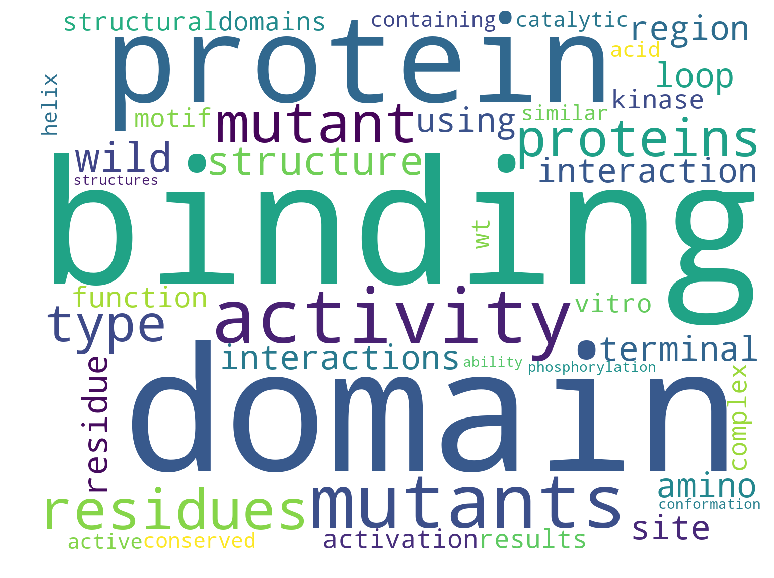

In [33]:
topWords(60)

The top words in those two topics fit well within the biological context. Words such as ``Domain'', ``binding'', ``interactions'', and ``catalytic'' all describe important molecular functions of a protein, which is characteristic of tumor suppressors that undergo loss-of-function mutations in cancer. The most salient word for Topic 20 is p53, the most well-known tumor suppressor in cancer disease mechanisms. Tumor suppressors are often controllers of cell cycle, and words such as ``cell cycle'', ``apoptosis'', ``loss [of a tumor suppressor]'' echo the oncogenic impact of tumor suppressor loss through cell cycle mechanisms.

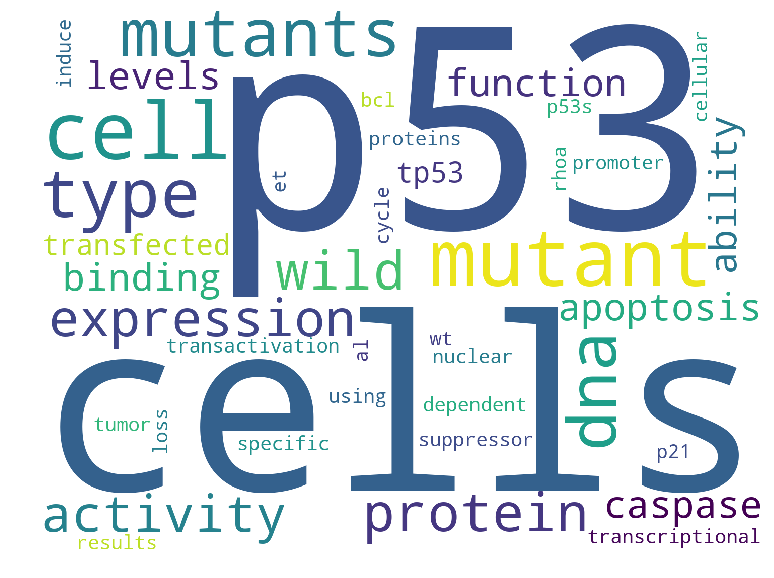

In [36]:
topWords(2)

# Salient topics for *Gain of Function* mutations

In [15]:
sorted(list(enumerate(mnb.feature_log_prob_[6])), key = lambda x: -x[1])[:5]

[(58, -1.6201617362745173),
 (92, -2.3118521299200792),
 (56, -2.3159109291923636),
 (60, -2.5573627927009586),
 (25, -2.581560019371139)]

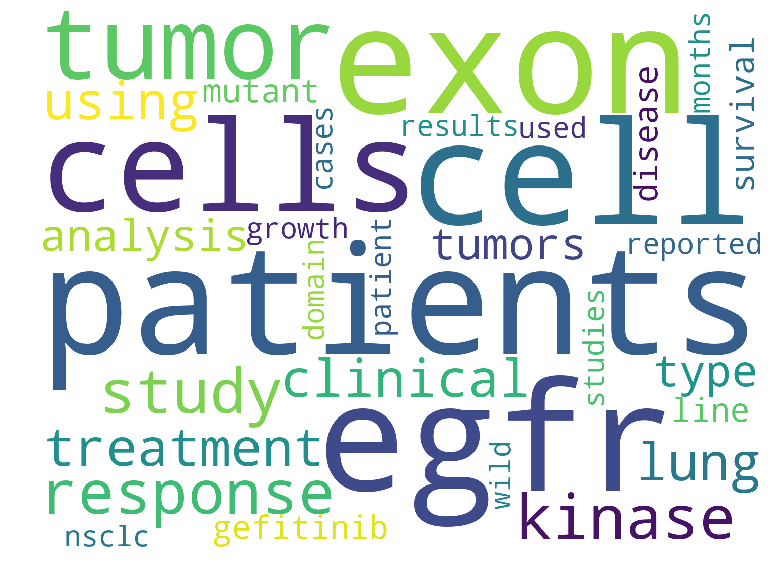

In [40]:
topWords(58)

# Calculate distance matrix of classes

Euclidean distance bewteen classes based on topic frequency vectors outputted by the multinomial NB

In [20]:
def calc_dist(i1, i2):
    dist = np.linalg.norm(mnb.feature_log_prob_[i2] - \
                      mnb.feature_log_prob_[i1])
    return dist

In [29]:
dist_matrix = pd.DataFrame([[calc_dist(j, i) for i in range(9)] for j in range(9)])
dist_matrix.columns = [index_to_class[i] for i in dist_matrix.columns]
dist_matrix.index = [index_to_class[i] for i in dist_matrix.index]
pd.DataFrame(dist_matrix[['Gain-of-function', 'Loss-of-function']])
dist_matrix

,Likely Loss-of-function,Likely Gain-of-function,Neutral,Loss-of-function,Likely Neutral,Inconclusive,Gain-of-function,Likely Switch-of-function,Switch-of-function
Likely Loss-of-function,0.000000,8.154083,10.981163,6.012803,7.387073,7.696421,9.692762,13.581416,12.605368
Likely Gain-of-function,8.154083,0.000000,10.066251,8.686116,7.868165,8.098386,5.003767,12.483533,11.545488
Neutral,10.981163,10.066251,0.000000,11.601596,6.600564,7.742129,13.525443,5.550884,5.484524
Loss-of-function,6.012803,8.686116,11.601596,0.000000,8.943511,8.921309,9.770549,14.706482,13.710884
Likely Neutral,7.387073,7.868165,6.600564,8.943511,0.000000,4.384067,11.105728,9.554763,8.831588
Inconclusive,7.696421,8.098386,7.742129,8.921309,4.384067,0.000000,11.232654,10.370804,9.703301
Gain-of-function,9.692762,5.003767,13.525443,9.770549,11.105728,11.232654,0.000000,16.396966,15.383589
Likely Switch-of-function,13.581416,12.483533,5.550884,14.706482,9.554763,10.370804,16.396966,0.000000,2.154677
Switch-of-function,12.605368,11.545488,5.484524,13.710884,8.831588,9.703301,15.383589,2.154677,0.000000


__Note that the closest neighbour of *Loss-of-function* is *Likely Loss-of-function* and similarly for *Gain-of-function*, which is closest to *Likely Gain-of-function*!__